$$ \newcommand{\IR}{\mathbb R}
\newcommand{\d}{\mathrm d}$$

# 1. Linear Classifiers (logistic regression and GDA)

## (a)

The loss function is 
$$ J(\theta) = -\frac 1m \sum_{i=1}^m y^{(i)}\log(h_\theta(x^{(i)}) + (1-y^{(i)}) \log(1- h_\theta(x^{(i)}))$$

where $y^{(i)}\in \{0,1\}, ~ h_\theta(x) = g(\theta^Tx) = g(x^T\theta)$ and $g(z)= 1/(1+e^{-z})$.

Recall that $g'(z) = (1-g(z))g(z)$.

Let $p(\theta) :=\log(h_\theta(x))$ for some vector $x$ of the same shape as $\theta$.

Then by the chain rule the Jacobian of $p$ at $\theta$ is
$$ \d_\theta p(\theta) = \frac 1{h_\theta(x))}g'(x^T\theta)x^T = (1-g(x^T\theta))x^T$$

Taking the transpose we get the gradient 
$$ \nabla_\theta p(\theta) = x(1-g(x^T\theta))$$

Differentiating again gives the Hessian:
$$ \nabla_\theta^2 p(\theta) = x(-g'(x^T\theta))x^T = -g'(x^T\theta)xx^T,$$
which is negative semidefinite because $g'$ is positive by monotony of $g$ and $xx^T$ is positive semi-definite.

Similarly for $q(\theta) := \log(1-h_\theta(x))$ we have 
$$ \nabla_\theta q(\theta) = -xg(x^T\theta)$$
and 
$$ \nabla^2_\theta q(\theta) = -g'(x^T\theta)xx^T$$
which is also negative semidefinite.

By linearity we conclude that the Hessian of $J$ has to be positive semidefinite.

Since we will need it for part (b), let's spell out the gradient and Hessian of $J$:

$$ \begin{align*}
\nabla_\theta J(\theta) &= 
-\frac 1m \sum_{i=1}^m x^{(i)} y^{(i)}(1-g(\theta^Tx^{(i)})) - x^{(i)}(1-y^{(i)})g(\theta^Tx^{(i)})\\
&= -\frac 1m \sum_{i=1}^m x^{(i)}(y^{(i)}-g(\theta^Tx^{(i)}))\\
&= -\frac 1m \sum_{i=1}^m x^{(i)}(y^{(i)}-h_\theta(x^{(i)}))
\end{align*}$$

$$ \begin{align*}
\nabla_\theta^2 J(\theta) &= \frac 1m \sum_{i=1}^m x^{(i)}(x^{(i)})^T g'(\theta^Tx^{(i)})\\
&= \frac 1m \sum_{i=1}^m x^{(i)}(x^{(i)})^T h_\theta(x^{(i)})(1-h_\theta(x^{(i)}))
\end{align*}$$

## (b)

In [1]:
import numpy as np
import src.util as util
from src.linear_model import LinearModel

Load the datasets:

In [2]:
class Dataset:
    def __init__(self, train_path, eval_path):
        self.x_train, self.y_train = util.load_dataset(train_path, add_intercept=False)
        self.x_val, self.y_val = util.load_dataset(eval_path, add_intercept=False)
        self.x_train_intercept, self.y_train_intercept = util.load_dataset(train_path, add_intercept=True)
        self.x_val_intercept, self.y_val_intercept = util.load_dataset(eval_path, add_intercept=True)
        
ds1 = Dataset('data/ds1_train.csv', 'data/ds1_valid.csv')
ds2 = Dataset('data/ds2_train.csv', 'data/ds2_valid.csv')

Let's take a look at the two training sets:

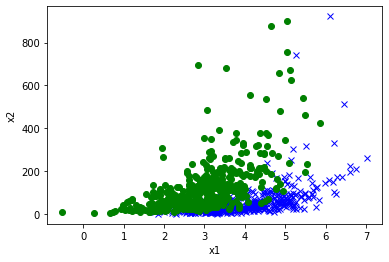

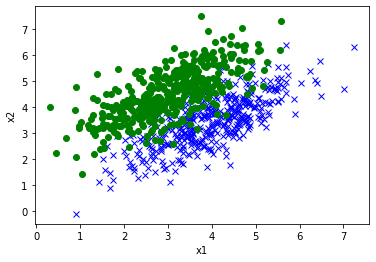

In [3]:
util.myplot(ds1.x_train, ds1.y_train)
util.myplot(ds2.x_train, ds2.y_train)

Implement functions to compute $h_\theta$, and the gradient and hessian of the loss function $J(\theta)$:

In [4]:
def h(theta, x):
    """vectorized implementation of h_theta(x)
    Args:
        theta: Shape (n,)
        x: Shape (m,n)
    
    Returns:
        numpy array of shape (m,)
    """
    return 1/(1+np.exp(-np.dot(x,theta)))

In [5]:
def gradient(x,y, theta):
    """
    Args:
        x: numpy array of shape (m,n)
        y: numpy array of shape (m,)
        theta: numpy array of shape (n,)
        
    """
    m, = y.shape
    return -1/m * np.dot(x.T, y - h(theta, x))

In [6]:
def hessian(x,y, theta):
    """
    Args:
        x: numpy array of shape (m,n)
        y: numpy array of shape (m,)
        theta: numpy array of shape (n,)
        
    """  
    m, = y.shape
    htx = np.reshape(h(theta,x), (-1,1))
    return 1/m * np.dot(x.T, x*htx*(1-htx))

Now we can define our logistic regression model:

In [7]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        def nexttheta(theta):
            grad = gradient(x,y,theta)
            H = hessian(x,y,theta)
            H_inv = np.linalg.inv(H)
            return theta - np.dot(H_inv, grad)
        
        
        m,n = x.shape
        theta_prev = np.zeros(n)
        theta_next = nexttheta(theta_prev)
        
        while np.linalg.norm(theta_prev - theta_next, 1) > self.eps:
            theta_prev = theta_next
            theta_next = nexttheta(theta_prev)
            
        self.theta = theta_next
        
        
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return (x @ self.theta) >= 0
        # *** END CODE HERE ***

Define a classifier and train it on our training data:

In [8]:
logreg1 = LogisticRegression()
logreg1.fit(ds1.x_train_intercept, ds1.y_train_intercept)

Finally, let's plot the decision boundary on the training set and on the validation set:

theta for dataset1: [-6.26018491  2.47707251 -0.0299125 ]


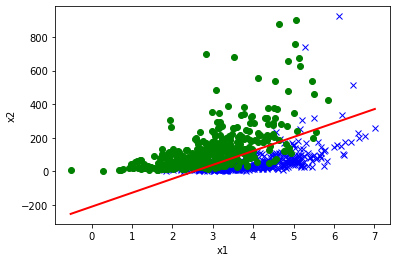

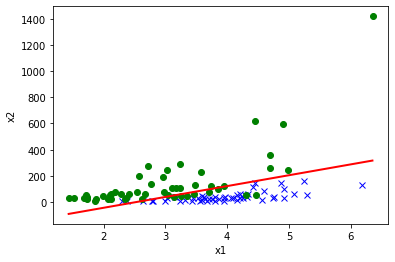

In [9]:
print("theta for dataset1:", logreg1.theta)
util.myplot(ds1.x_train, ds1.y_train, logreg1.theta)
util.myplot(ds1.x_val, ds1.y_val, logreg1.theta)

Let's do the same for dataset2:

theta for dataset2: [ 2.38425454  3.6371206  -3.81234337]


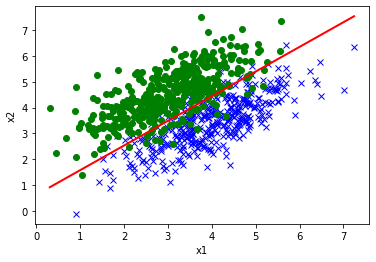

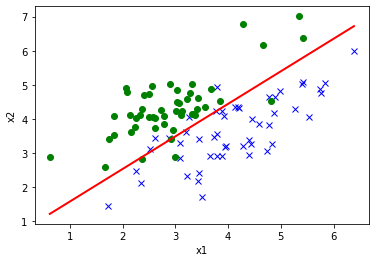

In [10]:
logreg2 = LogisticRegression()
logreg2.fit(ds2.x_train_intercept,ds2.y_train_intercept)

print("theta for dataset2:", logreg2.theta)
util.myplot(ds2.x_train, ds2.y_train, logreg2.theta)
util.myplot(ds2.x_val, ds2.y_val, logreg2.theta)

## (c)

By Bayes' rule we have

$$ \begin{align*}
p(y=1\mid x) &= \frac{p(y=1,x)}{p(x)}\\
&= \frac{p(y=1)p(x\mid y=1)}{p(x\mid y=1)p(y=1) + p(x\mid y=0)p(y=0)}\\
&= \frac{1}{1+\frac{p(x\mid y=0)p(y=0)}{p(x\mid y=1)p(y=1)}}\\
&= \frac {1}{ 1 + \exp\left(\color{red}{-\frac {1}{2}(x-\mu_0)^T\Sigma^{-1}(x-\mu_0)}+\color{blue}{\frac {1}{2}(x-\mu_1)^T\Sigma^{-1}(x-\mu_1)}\right)\frac {1-\phi}{\phi}}\\
&= \frac {1}{1+ \exp\left(
\color{red}{-\frac {1}{2} x^T\Sigma^{-1}x +\mu_0^T \Sigma^{-1}x -\frac {1}{2} \mu_0^T\Sigma^{-1}\mu_0} 
+ \color{blue}{\frac {1}{2} x^T\Sigma^{-1}x -\mu_1^T \Sigma^{-1}x +\frac {1}{2} \mu_1^T\Sigma^{-1}\mu_1}\right)\frac {1-\phi}{\phi}}\\
&= \frac{1}{1+\exp\left((\mu_0-\mu_1)^T\Sigma^{-1}x  -\frac {1}{2} \mu_0^T\Sigma^{-1}\mu_0 + \frac {1}{2} \mu_1^T\Sigma^{-1}\mu_1\right)\frac {1-\phi}{\phi}}
\end{align*}$$

So we can take $\theta = -\Sigma^{-1}(\mu_0-\mu_1)$ and $\theta_0= \frac {1}{2} \mu_0^T\Sigma^{-1}\mu_0 - \frac {1}{2} \mu_1^T\Sigma^{-1}\mu_1 - \log\frac {1-\phi}{\phi}$.

## (d)

Let's unpack the definition of $\ell$:

$$ \begin{align*}
\ell(\phi,\mu_0,\mu_1,\Sigma) &= \sum_{i=1}^m \left( \log p(x^{(i)}\mid y^{(i)}; \mu_0,\mu_1,\Sigma) + \log p(y^{(i)}; \phi) \right) \\
&= -m \log\left((2\pi)^{n/2}\lvert \Sigma \rvert^{1/2}\right)\\
&\phantom{=} -\frac {1}{2}\sum_{i=1}^m 1\{y^{(i)}=0\} \left( (x^{(i)}-\mu_0)^T\Sigma^{-1} (x^{(i)}-\mu_0) + \log (1-\phi)\right)\\
&\phantom{=} -\frac {1}{2}\sum_{i=1}^m 1\{y^{(i)}=1\} \left( (x^{(i)}-\mu_1)^T\Sigma^{-1} (x^{(i)}-\mu_1) + \log \phi\right)\\
\end{align*}
$$

At the maximum of $\ell$, we have $\d \ell =  (\d_\phi \ell, \d_{\mu_0}\ell, \d_{\mu_1}\ell, \d_{\Sigma}\ell)= 0$. 

For readability let's introduce $P:=\sum_{i=1}^m 1\{y^{(i)}=1\}$. We then have
$$\begin{align*} 
 0 &= -2\d_\phi \ell = \sum_{i=1}^m 1\{y^{(i)}=0\}\frac 1{\phi-1} + \sum_{i=1}^m 1\{y^{(i)}=1\}\frac 1\phi\\
 &= (m-P)\frac 1{\phi -1} + P \frac 1 \phi,
\end{align*}$$
which can be rearranged to
$$ \phi = \frac Pm = \frac 1m\sum_{i=1}^m 1\{y^{(i)}=1\},$$ 
as claimed.

Next we have 
$$\begin{align*} 
0&= \d_{\mu_0}\ell \\
&= \sum_{i=1}^m 1\{y^{(i)}=0\} (x^{(i)}- \mu_0)^T\Sigma^{-1},
\end{align*}$$
which is equivalent to 
$$ \mu_0 = \frac{\sum_{i=1}^m 1\{y^{(i)}=0\} x^{(i)}}{\sum_{i=1}^m 1\{y^{(i)}=0\} }.$$

The formula
$$ \mu_1 = \frac{\sum_{i=1}^m 1\{y^{(i)}=1\} x^{(i)}}{\sum_{i=1}^m 1\{y^{(i)}=1\} }$$
is derived similarly.

We now assume that $n=1$, so in particular $\Sigma \in \IR$ and every vector equals its own transpose. Then

$$\begin{align*} 
0&= \d_\Sigma \ell\\
&= -\frac m{2\Sigma}\\
&\phantom{=} +\frac {1}{2}\sum_{i=1}^m 1\{y^{(i)}=0\}  (x^{(i)}-\mu_0)^T\Sigma^{-2} (x^{(i)}-\mu_0)\\
&\phantom{=} +\frac {1}{2}\sum_{i=1}^m 1\{y^{(i)}=1\}  (x^{(i)}-\mu_1)^T\Sigma^{-2} (x^{(i)}-\mu_1),
\end{align*}$$

which simplifies to 

$$ \Sigma = \frac 1m \sum_{i=1}^m (x^{(i)}-\mu_{y^{(i)}}) (x^{(i)}-\mu_{y^{(i)}})^T$$

## (e)

In [11]:
class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***
        # Find phi, mu_0, mu_1, and sigma
        # Write theta in terms of the parameters
        
        m,n = x.shape
        y_vec = np.reshape(y,(-1,1))
        
        phi= 1/m * np.sum(y)
        mu_0 = np.sum(x*(1-y_vec), axis= 0) / np.sum(1-y)
        mu_1 = np.sum(x*y_vec, axis=0) / np.sum(y)
        mu_x = y_vec*mu_1 +(1-y_vec)*mu_0 # shape (m,n)
        x_norm = x-mu_x
        sigma = 1/m * np.dot(x_norm.T, x_norm)
        
        sigma_inv = np.linalg.inv(sigma)
        
        theta = -np.dot(sigma_inv,mu_0 - mu_1)
        theta0 = np.array([1/2* mu_0 @ sigma_inv @ mu_0 -1/2* mu_1 @ sigma_inv @ mu_1 -np.log((1-phi)/phi)])
        self.theta = np.concatenate((theta0, theta))
        
        return self.theta
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        x_intercept = util.add_intercept(x)
        #return 1/ (1+ np.exp(-x_intercept @ self.theta))
        return x_intercept @ self.theta >= 0
        # *** END CODE HERE


Let's train a GDA classifier for dataset 1 and plot the learned decision boundary on the training and the validation set.

theta for dataset1: [-6.17158405  2.22055506 -0.01763375]


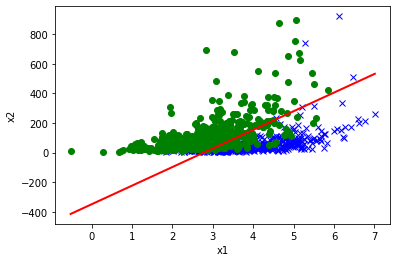

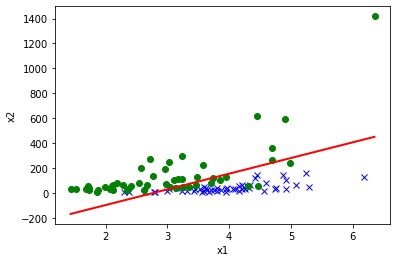

In [12]:
gda1 = GDA()
gda1.fit(ds1.x_train, ds1.y_train)

util.myplot(ds1.x_train,ds1.y_train, gda1.theta)
util.myplot(ds1.x_val,ds1.y_val, gda1.theta)
print("theta for dataset1:",gda1.theta)

The same for dataset 2:

theta for dataset2 [ 2.50874989  3.76951271 -3.94657107]


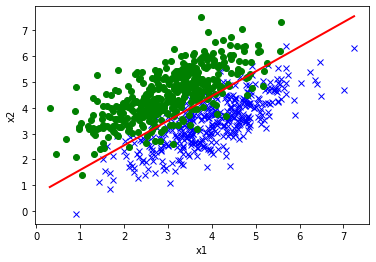

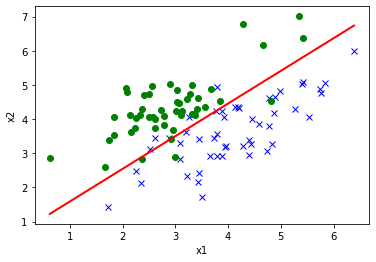

In [13]:
gda2 = GDA()
gda2.fit(ds2.x_train, ds2.y_train)

util.myplot(ds2.x_train,ds2.y_train, gda2.theta)
util.myplot(ds2.x_val, ds2.y_val, gda2.theta)
print("theta for dataset2" ,gda2.theta)

## (f)

**Decision boundaries on dataset 1** (Logistic regression in red, GDA in black):

theta for logistic regression: [-6.26018491  2.47707251 -0.0299125 ]
                theta for GDA: [-6.17158405  2.22055506 -0.01763375]


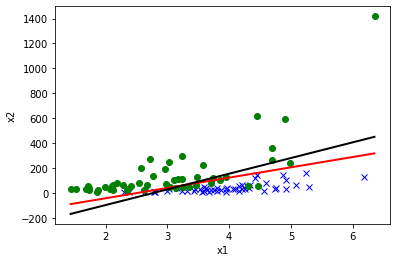

In [14]:
util.myplot(ds1.x_val, ds1.y_val, logreg1.theta, gda1.theta)
print("theta for logistic regression:",logreg1.theta)
print("                theta for GDA:", gda1.theta)

## (g)

**Decisionboundaries on dataset 2** (Logistic regression in red, GDA in black):

theta for logistic regression: [ 2.38425454  3.6371206  -3.81234337]
                theta for GDA: [ 2.50874989  3.76951271 -3.94657107]


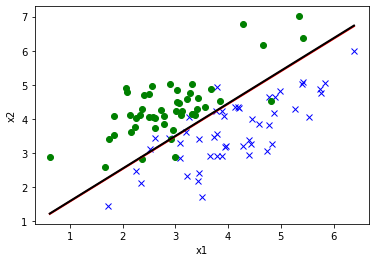

In [15]:
util.myplot(ds2.x_val, ds2.y_val, logreg2.theta, gda2.theta)
print("theta for logistic regression:",logreg2.theta)
print("                theta for GDA:", gda2.theta)

To compare the models, let's compute their accuracies:

In [16]:
def accuracy(clf, x_val, y_val):
    y_pred = clf.predict(x_val)
    #print(y_pred)
    correct = np.sum(y_pred == y_val)
    total = y_val.shape[0]
    return correct / total

In [17]:
logreg1_acc = accuracy(logreg1, ds1.x_val_intercept, ds1.y_val)
logreg2_acc = accuracy(logreg2, ds2.x_val_intercept, ds2.y_val)
gda1_acc = accuracy(gda1, ds1.x_val, ds1.y_val)
gda2_acc = accuracy(gda2, ds2.x_val, ds2.y_val)

print("Accuracies on dataset 1:")
print("Logistic regression:", logreg1_acc)
print("                GDA:", gda1_acc)
print("********************************")
print("Accuracies on dataset 2:")
print("Logistic regression:", logreg2_acc)
print("                GDA:", gda2_acc)

Accuracies on dataset 1:
Logistic regression: 0.9
                GDA: 0.83
********************************
Accuracies on dataset 2:
Logistic regression: 0.91
                GDA: 0.91


So while both logistic regression and GDA seem to have the same performance on dataset 2, GDA performs worse on dataset 1.

The reason for this is that dataset 1 doesn't fit the model assumptions of GDA as well as dataset 2, i.e. the data in dataset 1 does not fit well to a multivariate gaussian distribution.

## (h)

Let's have another look at dataset 1:

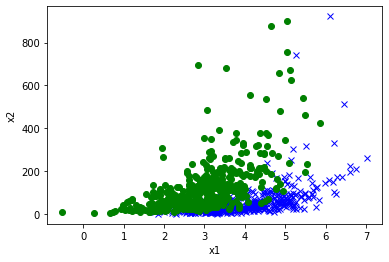

In [18]:
util.myplot(ds1.x_train, ds1.y_train)

The $x_2$ values of both classes seem to be positive and there seem to be many values close to $0$. Let's transform the data by applying $\log$ to $x_2$ and leaving $x_1$ unchanged.

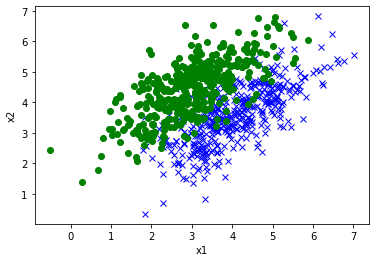

In [19]:
transform = lambda x: np.stack((x[:,0], np.log(x[:,1])), axis=1)

x_train = transform(ds1.x_train)
util.myplot(x_train, ds1.y_train)

This looks more gaussian. Let's fit a GDA model to the transformed dataset:

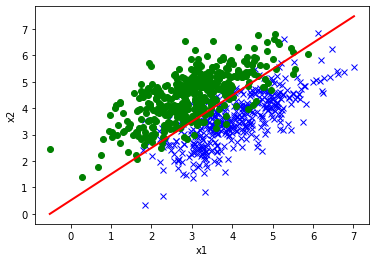

In [20]:
gda3 = GDA()
gda3.fit(x_train, ds1.y_train)
util.myplot(x_train,ds1.y_train, gda3.theta)

Finally let's check if we could improve the accuracy:

In [21]:
x_val = transform(ds1.x_val)
gda3_acc = accuracy(gda3,x_val, ds1.y_val)
print("   GDA accuracy on original dataset1:", gda1_acc)
print("GDA accuracy on transformed dataset1:", gda3_acc)

   GDA accuracy on original dataset1: 0.83
GDA accuracy on transformed dataset1: 0.95


This is a much better fit.

Just for fun let's also train a logistic regression model on the transformed dataset and then compare its performance to our new GDA model.

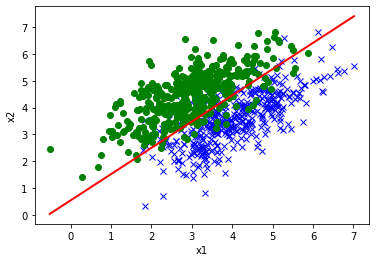

In [22]:
logreg3 = LogisticRegression()
x_train_intercept = util.add_intercept(x_train)
logreg3.fit(x_train_intercept, ds1.y_train)
util.myplot(x_train,ds1.y_train, logreg3.theta)

In [23]:
x_val_intercept = util.add_intercept(x_val)
logreg3_acc = accuracy(logreg3,x_val_intercept, ds1.y_val)
print("Logistic regression accuracy on transformed dataset1:", logreg3_acc)
print("                GDA accuracy on transformed dataset1:", gda3_acc)

Logistic regression accuracy on transformed dataset1: 0.95
                GDA accuracy on transformed dataset1: 0.95


theta for logistic regression (red): [ 1.96299173  3.56623663 -3.64318719]
              theta for GDA (black): [ 1.89345089  3.69641657 -3.71982993]


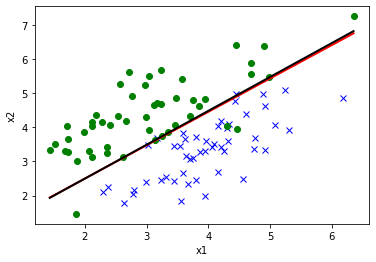

In [24]:
print("theta for logistic regression (red):", logreg3.theta)
print("              theta for GDA (black):",gda3.theta)
util.myplot(x_val, ds1.y_val, logreg3.theta, gda3.theta)